# Heartbeat categorization

_Random forest classification with >90% accuracy and other key performance measures._

**Author** <br>
> Simone Maria Giancola <br>
simonegiancola09@gmail.com <br>
+39 3314788683 <br>
Linkedin Profile: [Simone Giancola](https://www.linkedin.com/in/simone-maria-giancola-011465173/) <br> 
Github Profile: [@simonegiancola09](https://github.com/simonegiancola09)

I am absolutely not a professional, so any suggestion, either typo, code, writing, or analysis related is highly appreciated, and will be welcomed with enthusiasm.

## Description

While attending university I had the opportunity to learn the basics of Python and some of its libraries. This is one of the attempts of satisfying my personal taste with projects that could also be useful. <br>
After having attended the Machine Learning course at Bocconi University, I felt motivated enough to apply the knowledge acquired in the healthcare setting. <br>
[Kaggle](https://www.kaggle.com/) was a good starting point. There I found the dataset I will work with in the following notebook. More information can be found at the following link: <br>
   * [Big Dataset](https://www.kaggle.com/shayanfazeli/heartbeat?select=mitbih_train.csv) <br>

> Technical and knowledge sources vary from across the internet, libraries documentation, and lecture notes of the Python courses I had at Bocconi University. The framework, notation and main idea recalls that of the Machine Learning course I already mentioned, where I used as a textbook: "_Hands on Machine Learning with Scikit-learn Keras and Tensorflow_". <br>

In order to avoid writing an enormous document, I leave to the writer the option to review data sources, description of features and acknowledgements. <br>
I will develop a process of thought to analyze data, adapting it to the needs of each piece of information, to see its results. <br>
I suggest reading this along with the other analysis I did at the following link: <br>
[Github Repository](https://github.com/simonegiancola09/heart_datasets_ML)

In the event that the reader is curious of the result only, I suggest skipping all chapters up to "Pipeline and Ensemble". From now onwards, I will present my reasoning with words and numbers, with more details than a simple script. I suggest to give at least a look at data visualization cells across the whole notebook. 

**IMPORTANT**
> Being quite big, my Jupyter environment did not load a table of contents at the beginning, making it very difficult to navigate the document. Gooogle Colab has a built in table of contents on the left. This also makes Jupyter reading kind of painful since I put numbers to heading by hand and they would not match those of Jupyter.

> The first dataset in the repository is smaller. However, the theory behinf the methods used is presented there, and not in this analysis. Thus, if the reader is curios about the formulas and reasonings involved, he/she can click on the repository link above. I would also point out that most of the models I found online had a higher accuracy but a low CV score (around 30% less), meaning less reliability. My model, though less accurate, seems to be more robust. 

### Problem Definition

The task falls into the world of supervised learning with a classifier: attempting to create a model which could predict a discrete label given all the other features of an individual observation. <br>
In particular, we have a multilabel dataset with 5 kinds of heartbeats and relative sampled beats for each individual at a given frequence of sampling. Basically a beat is observed through a finite number of samples for each individual belonging to a precise category, denoting either a disease or a normality condition. <br>


---


**I managed to create a classifier which taking a single heartbeat can identify the disease more than 90% of the times, with over 90% scores for many main performance evaluators.**

# Analysis

### 1 Libraries import, basic settings

Below the basic libraries, functions and variables needed for the whole notebook. Those are the same of the other document, so I just copied and pasted from it. If the reader is interested in checking where they are specifically imported or developed the link to the whole repository is in the description. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import io
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
import seaborn as sns
from pandas.plotting import scatter_matrix

In [ ]:
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from numpy import unravel_index
from sklearn.metrics import precision_score,recall_score,f1_score
from matplotlib import cm

In [ ]:
skf=StratifiedKFold(n_splits=10)

In [ ]:
def clash(d1,d2,X_d1,X_t_d1,X_d2,X_t_d2,y,y_t,skf):
    best_d1=None
    best_score_d1=0
    best_d2=None
    best_score_d2=0
    print('Original full features estimators: \n')
    for key in d1.keys():
        score=np.mean(cross_val_score(d1[key],X_d1,y,cv=skf))
        print('Cv score with',key,'is:',score)
        if score>best_score_d1:
                      best_d1=key
                      best_score_d1=score
    print('\n Reduced features estimators: \n')
    for key in d2.keys():
        score=np.mean(cross_val_score(d2[key],X_d2,y,cv=skf))
        print('Cv score with',key,'is:',score)
        if score>best_score_d2:
                      best_d2=key
                      best_score_d2=score
    print('\n The dictionaries of classifiers have been exhaustively searched. \n ',
          '\n Test set final analysis')
    acc_d1=accuracy_score(d1[best_d1].predict(X_t_d1),y_t)
    acc_d2=accuracy_score(d2[best_d2].predict(X_t_d2),y_t)
    print('For the first dictionary the best one found is:', best_d1,
          '\n With a cv score of:',best_score_d1,'\n And a test set accuracy of:',
         acc_d1)
    print('For the second dictionary the best one found is:', best_d2,
          '\n With a cv score of:',best_score_d2,'\n And a test set accuracy of:',
         acc_d2)
    if best_score_d1>best_score_d2:
                      best_overall=best_d1
                      fr='first'
    else:
                      best_overall=best_d2
                      fr='second'
    print('Overall, the most reliable one is:',best_overall,'from the',fr,'dictionary')
    return best_overall, fr


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
import time
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

I also chose to avoid warnings by filtering them. 

In [ ]:
warnings.filterwarnings('ignore')

To make the library randomly consistent we set the seed to a precise number. Doing so, any insight on data will be constantly the same even if the library is run again. 
IMPORTANT: I experienced issues along the notebook in terms of reproducibility of the same result, especially with respect to performance measures. Now that it is finished, I realized that by simply setting the seed this cannot be avoided, since it only determines the starting number of the random series, and not all of them, thus causing different Cross Validation results (due to different samples taken at each iteration) and different accuracies. A solution might have been setting in sklearn functions involving randomness:
$$random\_state=always \; the \; same \;number$$
Nevertheless, I decided not to do so since the deviation was low (below 5%) and so choosing one estimator with CV score 0.something and another with CV score 0.something+5% would not have influenced much the conclusions, which anyway include all the possible options and do not exclude some estimators due to performance. 
Moreover, a good classifier should be robust to the seed set (robust to randomness), so in a real setting it would have made much more sense also to avoid setting the starting seed. 

In [ ]:
np.random.seed(9)

Matplotlib default colors are not the best aesthetically speaking, so here is a code I found online that slightly changes them. Not needed at all. It did not require any kind of effort (just a copy and paste). Colors do not change much. 

In [ ]:
plt.style.use('seaborn-bright')

### 2 Data loading, cleaning and first analysis

In [ ]:
#df is the train set
df=pd.read_csv('/content/mitbih_train.csv',header=None)
test=pd.read_csv('/content/mitbih_test.csv',header=None)
df.rename(columns={187: 'label'}, inplace=True)
test.rename(columns={187:'label'},inplace=True)

The dataset is quite big, the next cells allow to give a first look at it. Categories range from 0 to 4 and denote a precise condition for the individual's hearthbeat.  

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,0.052632,0.140351,0.119298,0.091228,0.140351,0.161404,0.105263,0.143860,0.143860,0.129825,0.147368,0.157895,0.164912,0.168421,0.154386,0.175439,0.164912,0.154386,0.182456,0.192982,0.196491,0.207018,0.217544,0.217544,0.256140,0.284211,0.294737,0.301754,0.301754,0.322807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,0.078333,0.183333,0.275000,0.315000,0.361667,0.430000,0.481667,0.526667,0.543333,0.563333,0.581667,0.588333,0.600000,0.603333,0.613333,0.62

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to label
dtypes: float64(188)
memory usage: 125.6 MB


In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,label
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,0.198778,0.203550,0.208776,0.212885,0.218393,0.224966,0.231377,0.237123,0.242582,0.247923,0.253749,0.259748,0.266244,0.272734,0.279355,0.285588,0.291808,0.297672,0.303384,0.308795,0.313890,0.318454,0.322087,0.324891,0.326737,0.327817,0.327931,0.326746,0.324326,0.320537,...,0.030729,0.029582,0.028531,0.027573,0.026875,0.025771,0.024823,0.023932,0.023060,0.022458,0.021809,0.021245,0.020623,0.020026,0.019534,0.019053,0.018592,0.017664,0.016740,0.015722,0.014402,0.013024,0.011625,0.010262,0.008929,0.008056,0.007278,0.006531,0.005981,0.005479,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,0.171796,0.176496,0.180274,0.184101,0.186963,0.190002,0.193899,0.198465,0.202855,0.207166,0.211187,0.214821,0.218450,0.221486,0.224031,0.225848,0.227133,0.227830,0.228436,0.228871,0.228760,0.228393,0.227472,0.226180,0.224659,0.223110,0.221352,0.219258,0.216884,0.214168,...,0.116516,0.114463,0.112686,0.111103,0.110513,0.108566,0.106493,0.104591,0.102658,0.101395,0.100201,0.099386,0.098327,0.096635,0.095729,0.095368,0.095055,0.092902,0.091118,0.088574,0.084638,0.079949,0.075307,0.069892,0.063994,0.060074,0.056404,0.052840,0.050006,0.046693,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,0.070543,0.069182,0.068293,0.067744,0.070175,0.072993,0.074803,0.075972,0.076923,0.077872,0.079442,0.081911,0.085938,0.090032,0.094595,0.098901,0.103960,0.109348,0.114754,0.120730,0.127946,0.135962,0.144295,0.151852,0.157895,0.161035,0.161133,0.159383,0.157343,0.155388,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

As the link explains, it is composed of 187 features, and one label for each of the 87553 elements. 

Given that each feature is a sampling time, I find it more useful to provide a sample plot of typical heartbeat for each category. 

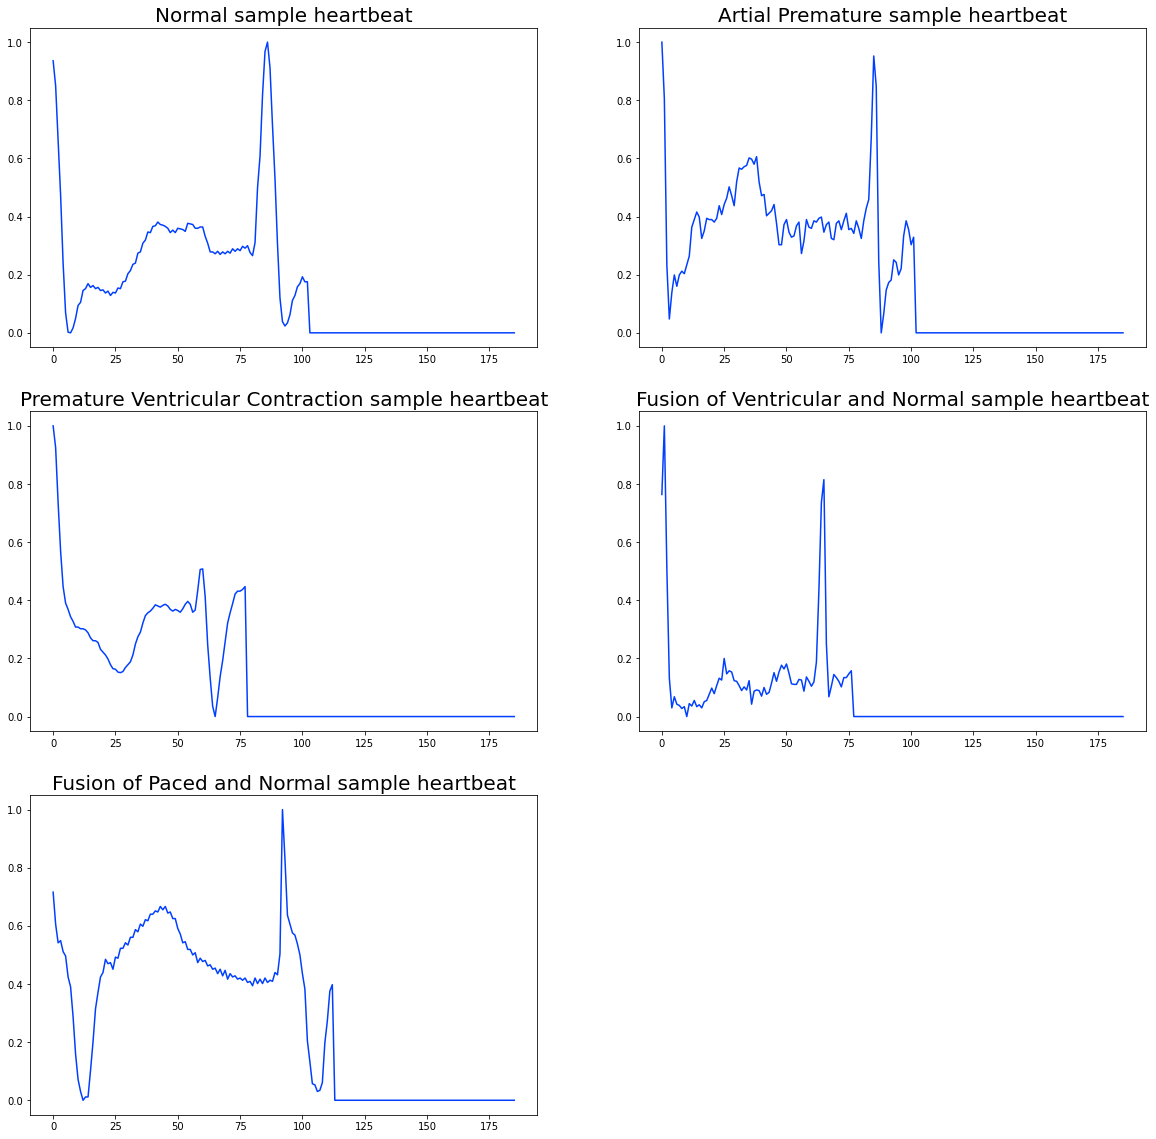

In [ ]:
df_0=df[df['label']==0]
df_1=df[df['label']==1] 
df_2=df[df['label']==2] 
df_3=df[df['label']==3] 
df_4=df[df['label']==4]
cats=['Normal','Artial Premature','Premature Ventricular Contraction',
      'Fusion of Ventricular and Normal','Fusion of Paced and Normal']

df_cat_list=[df_0,df_1,df_2,df_3,df_4]
fig=plt.figure(figsize=(20,20))
i=1 #subplot and type counter
for df_cat in df_cat_list:
    ax=fig.add_subplot(3,2,i)
    ax.set_title(f'{cats[i-1]} sample heartbeat',fontsize=20)
    ax.plot(df_cat.iloc[np.random.randint(0,df_cat.shape[0]),:186])    
    i+=1


To visualize more categories' differences below I will plot them in the same graph.

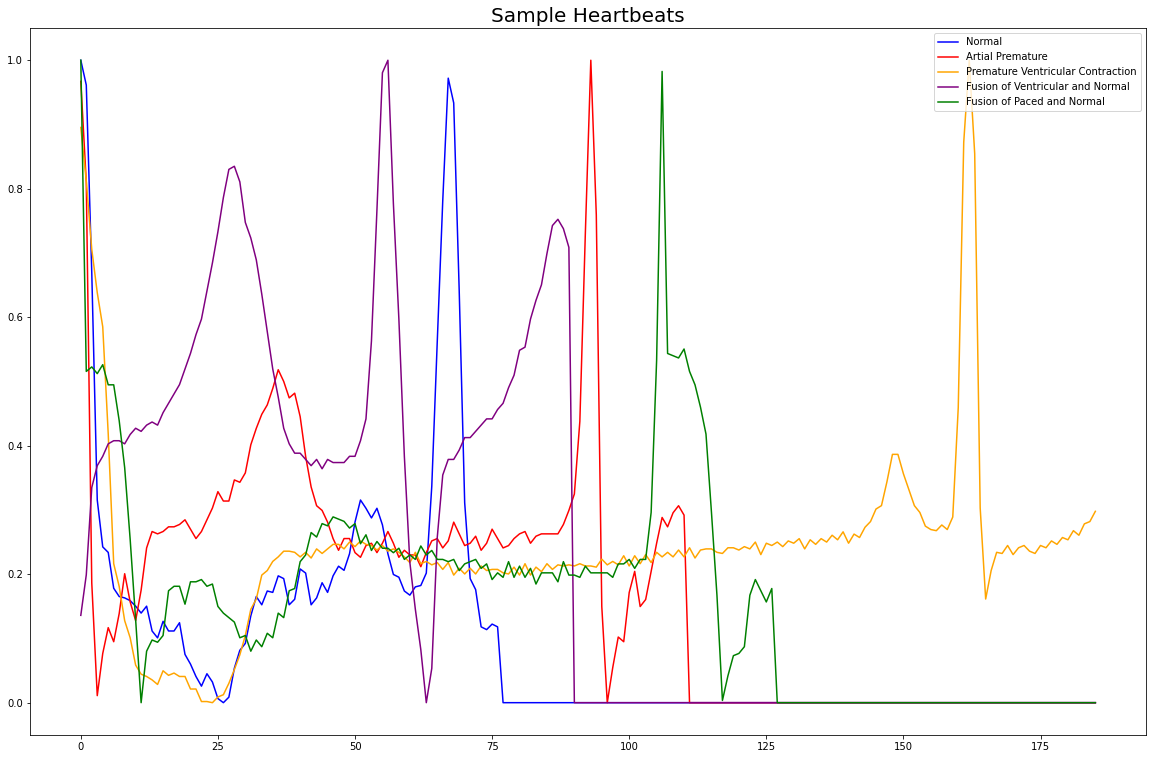

In [ ]:
plt.figure(figsize=(20,13))
plt.title('Sample Heartbeats',fontsize=20)

colors=['blue','red','orange','purple','green','brown']
i=1 #subplot and type counter
for df_cat in df_cat_list:
    plt.plot(df_cat.iloc[np.random.randint(0,df_cat.shape[0]),:186],
             color=colors[i-1],label=cats[i-1])    
    i+=1
plt.legend()

Labels are not "continuous", they take 5 values, 0 to 4, and they are highly unbalanced, as we can see below. This last issue will be dealt later in the notebook. 

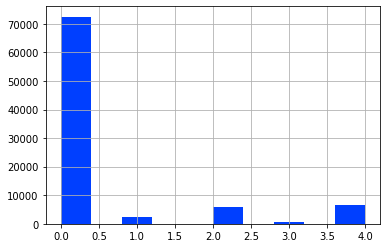

In [ ]:
df.label.hist()

To check if some values weigh more in determining the label, one may greedily see if some features are highly correlated with the it. This is not the case, tough, as the function in the next cell suggests: each feature has an absolute correlation below 0.6 with the resulting label. The presence of many mildly correlated indices is good anyway. I do not personally understand why but some intervals seem to be more important than others. Again, experience in the field could be useful. 

In [ ]:
df.corr()['label'].sort_values(ascending=False)

label    1.000000
3        0.508486
4        0.508453
5        0.408177
100      0.378922
           ...   
129     -0.064216
130     -0.064256
131     -0.065139
0       -0.166175
1       -0.183442
Name: label, Length: 188, dtype: float64

### 3 Features' observations

In [1]:
#not imported in the other notebook
from sklearn.utils import resample

The distribution of labels is as follows:

In [ ]:
df.label.value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: label, dtype: int64

For what concerns training, first I will tackle label imbalance. 

It is evident that labels are imbalanced in the train set "df"

A model of this kind could have a relatively high accuracy just by classifying everything as "0". To avoid this I will use the resample method, which seems to be the easiest one, to adjust imbalance and create a train dataframe with the same proportion of categories. I chose 2500 each as a starting point but this could be argued 

In [ ]:
df_0_res=df_0.sample(n=2500) #has more than 2500 features
df_1_res=resample(df_1,n_samples=2500,replace=True)
df_2_res=resample(df_2,n_samples=2500,replace=True)
df_3_res=resample(df_3,n_samples=2500,replace=True)
df_4_res=resample(df_4,n_samples=2500,replace=True)
df_cat_list_res=[df_0_res,df_1_res,df_2_res,df_3_res,df_4_res]
df=pd.concat([df_0_res,df_1_res,df_2_res,df_3_res,df_4_res])


Now we check again label counts, and eventually divide in labels and features

In [ ]:
df.label.value_counts()

4.0    2500
3.0    2500
2.0    2500
1.0    2500
0.0    2500
Name: label, dtype: int64

Evidence of multicollinearity may suggest dropping some features, but a 188x188 matrix would not be understandable. I will only evaluate with code and avoid visualization. 

I will print the maximum and minimum values of intercorrelation between features, using the unstack function and a numpy mask to index those below 1 and above -1. The reasoning is that, since we assume there is no correlation of 1 between features, if not in the diagonal, we can exclude them and find the maximum-non-extreme correlation. I find this more user friendly rather than evaluating the highest value in the low triangle of the matrix with a long function. 

In [ ]:
corr_mat=df.corr()
print('highest-non-extreme correlation',corr_mat.unstack()[df.corr().unstack()<1.0].max())
print('lowest-non-extreme correlation',corr_mat.unstack()[df.corr().unstack()>-1.0].min())
corr_mat=corr_mat.abs() #absolute values for further discussion

highest-non-extreme correlation 0.9965873004651743
lowest-non-extreme correlation -0.6649026014875309


There is clear evidence of multicollinearity. I may save some time by dropping some of these variables. Despite not liking accessing the matrix in a less user friendly way, I did not manage to find a better method. 

In [ ]:
corr_mat=corr_mat.to_numpy()
corr_mat[corr_mat==1]=0 #set diagonal as 0 since we do not mean to delete it
mask=corr_mat>0.95 #we will delete features with more than 95% correlation
over_95=[]
for i in range(corr_mat.shape[0]):
    l=range(i)
    for j in l:
        if corr_mat[i,j]>0.95:
            over_95.append([(i,j)])


In [ ]:
print('Number of couples with over 95% correlation:', len(over_95))

Number of couples with over 95% correlation: 221


Many features seem to tell the same thing, so I decided to drop only those correlated more than 98%, and even numbered, so half of them. This decision does take into account the fact that, being a sequential sampling of the same individual, adiacent samples are highly correlated, but this means anyway that many could be ignored. 

In [ ]:
over_98=[]
for i in range(corr_mat.shape[0]):
    l=range(i)
    for j in l:
        if corr_mat[i,j]>0.95:
            over_98.append((i,j))
over_set=set()
for tup in over_98:
    if tup[0] not in over_set:
        over_set.add(tup[0])
for i in range(len(over_set)):
    x=max(over_set) #we remove from the maximum element in order 
                    #not to lose the information of the index
                    #otherwise we would remove lower indexes and could go out of bounds
    if x//2:
        df.drop(df.columns[x],axis=1,inplace=True)
    over_set.remove(x)    

In [ ]:
df.shape

(12500, 63)

Now the shape of the dataframe is a lot smaller, with 63 features. 

Below a new plot of the simplified heartbeats with less variables

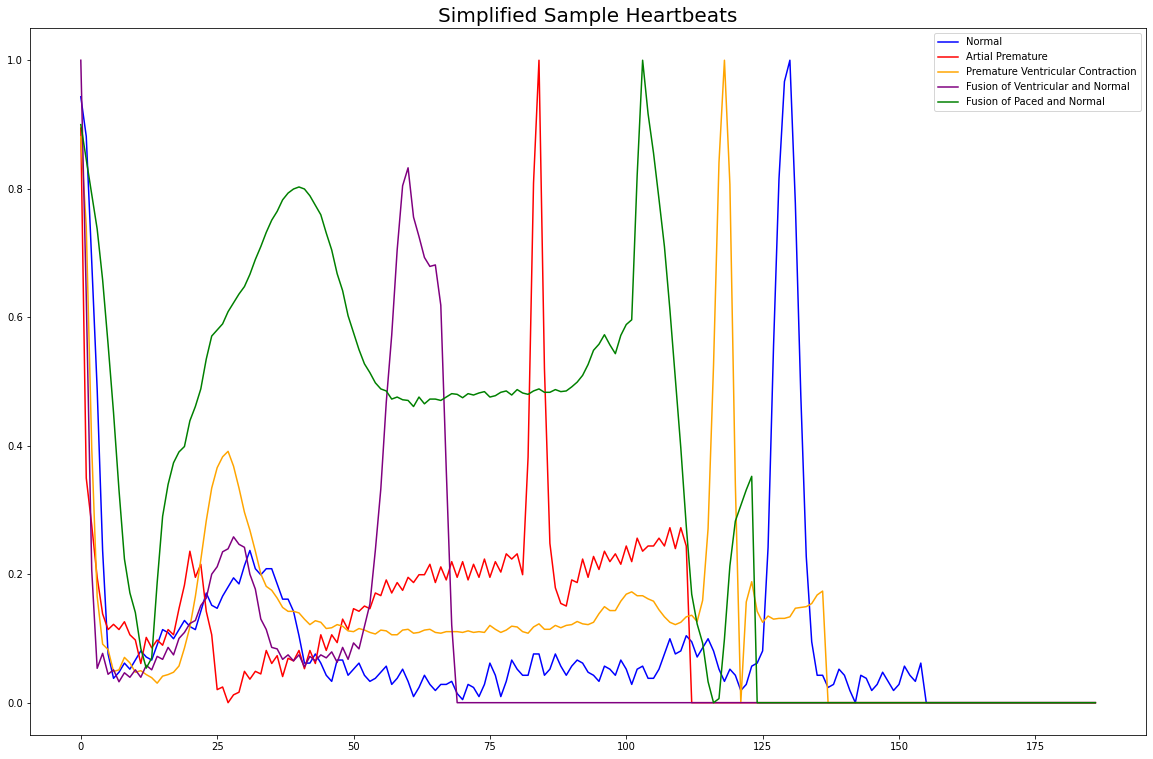

In [ ]:
plt.figure(figsize=(20,13))
plt.title('Simplified Sample Heartbeats',fontsize=20)

colors=['blue','red','orange','purple','green','brown']
i=1 #subplot and type counter
for df_cat in df_cat_list_res:
    plt.plot(df_cat.iloc[np.random.randint(0,df_cat.shape[0]),:df_cat.shape[1]-1],
             color=colors[i-1],label=cats[i-1])    
    i+=1
plt.legend()

Lastly, I decided to avoid doing feature engineering because I believe I do not have the knowledge to attempt creating new variables with a clear scientific justification for doing so. I am not an expert in matters of heart disease diagnosis or ECG in general. 

We can eventually create the train and test matrices and targets:

In [ ]:
X_train=df.drop(['label'],axis=1)
y_train=df['label']

In [ ]:
for tup in over_98:
    if tup[0] not in over_set:
        over_set.add(tup[0])
for i in range(len(over_set)):
    x=max(over_set) #we remove from the maximum element in order 
                    #not to lose the information of the index
                    #otherwise we would remove lower indexes and could go out of bounds
    if x//2:
        test.drop(test.columns[x],axis=1,inplace=True)
    over_set.remove(x)

X_test,y_test=test.drop(['label'],axis=1),test['label']


#the test set should follow the same reasoning for what concerns removing variables. 

### 4 PCA digression and visualization

Dealing with a high dimensional dataset, one solution might be dimensionality reduction. This could prove to be useful, since choosing orthogonal directions of variance could reduce noise in the dataset, while decreasing computational costs. The following chapter analyzes whether or not this choice might be the right one and attempts to visualize the dataset in 2 and 3 dimensions to make it more understandable. 

The graph reported below shows the relationship between the number of components chosen and the fraction of variance obtained.

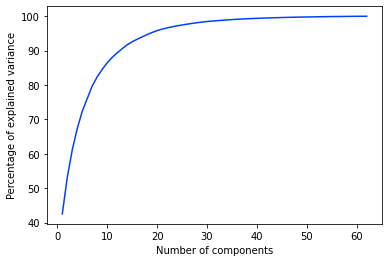

In [ ]:
pca=PCA()
pca.fit(X_train)
components=np.arange(1,X_train.shape[1]+1)
fig,ax=plt.subplots()
ax.plot(components,np.cumsum(pca.explained_variance_ratio_*100))
ax.set_xlabel('Number of components')
ax.set_ylabel('Percentage of explained variance')
fig.show()

Growth is not linear, underlining that some directions store more information than some others, a good choice, in terms of computational time, might be between 20 and 30, where the explained variance reaches more than 90% of its maximum. In others words, more or less 1/2 of the dimension grants more than 90% of the information. To be more "lecture consistent" also 95% of the variance, paying with some more time for computations, can be achieved with relatively few directions. This choice will be dealt with later. 

Another great potential in PCA's scope of application is visualization. Below training data is transformed in two and three dimensions to be plotted in cartesian planes.

In [ ]:
pca_2=PCA(n_components=2)
pca_3=PCA(n_components=3)
pca_2.fit(X_train)
pca_3.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X_trans_2=pca_2.transform(X_train)
X_trans_3=pca_3.transform(X_train)

For the sake of visualization, the plots are as follows, with each point colored as its label.

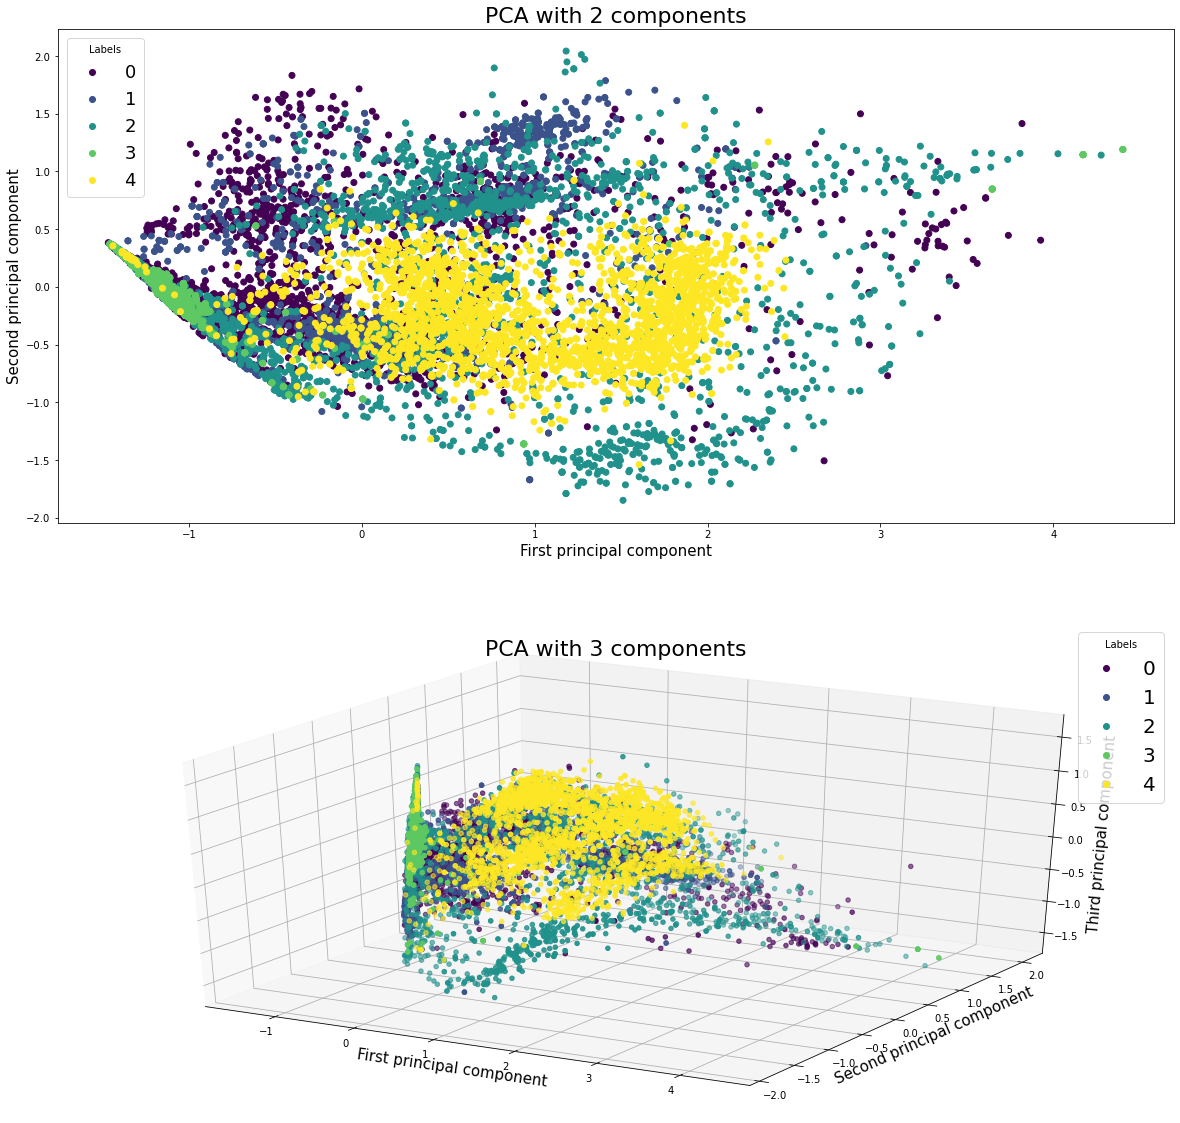

In [ ]:
fig=plt.figure(figsize=(20,20))
ax1=fig.add_subplot(2,1,1)
one=ax1.scatter(X_trans_2[:,0],X_trans_2[:,1],c=y_train)
ax1.legend(*one.legend_elements(),title='Labels',fontsize=18)
ax1.set_xlabel('First principal component',fontsize=15)
ax1.set_ylabel('Second principal component',fontsize=15)

ax1.set_title('PCA with 2 components',fontsize=22)
ax2=fig.add_subplot(2,1,2,projection='3d')
two=ax2.scatter(X_trans_3[:,0],X_trans_3[:,1],X_trans_3[:,2],c=y_train)
ax2.legend(*one.legend_elements(),title='Labels',fontsize=20)
ax2.set_xlabel('First principal component',fontsize=15)
ax2.set_ylabel('Second principal component',fontsize=15)
ax2.set_zlabel('Third principal component',fontsize=15)


ax2.set_title('PCA with 3 components',fontsize=22)
fig.show()

Obviously, showing the behavior of a 64-dimensional dataset in 2 or 3 dimensions is highly meaningless in most of the cases. There is no evidence of clusters of labels, but a hint can be read between the lines. 

In [ ]:
print('When choosing two dimensions ',np.cumsum(pca_3.explained_variance_ratio_)[-2]
      ,' percent of the variance is saved \n','When choosing three dimensions '
      ,np.cumsum(pca_3.explained_variance_ratio_)[-1],
      ' percent of the variance is saved')

When choosing two dimensions  0.5314748445927414  percent of the variance is saved 
 When choosing three dimensions  0.6112352002671599  percent of the variance is saved


Going back to the time computation vs performance tradeoff, after some thought, I decided to store more than 95% of the variance, and compare it with the performance of the non-transformed dataset. Doing so, at least one of the two processes will require less time, and I will be able to compare the two choices (relatively strong reduction and no reduction at all). This line of thought is neither supported by evidence of data, nor contested, with no knowledge on the nature of the dataset, any reasoning concerning working on data is neither right nor wrong, as for the transformation of features. Nevertheless, having as task the duty of "achieving the best possible performance in the least amount of time" lead me to this path. It could also be argued that capturing that portion of the variance with 10 dimensions less is better, but we would not be able to assess the impact of each feature since they were all transformed.

In [ ]:
pca_best=PCA(n_components=0.95)
pca_best.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

We have that the explained variance ratio is:

In [ ]:
print('Explained variance: ',np.cumsum(pca_best.explained_variance_ratio_)[-1])

Explained variance:  0.9528209443496101


With a number of components equal to:

In [ ]:
print('Number of components: ',pca_best.n_components_)

Number of components:  19


I now transform both the train and the test set as to make them both consistent with the same classifier. 

In [ ]:
X_train_90=pca_best.transform(X_train)
X_test_90=pca_best.transform(X_test)

The next chapter will go on with a parallel performance evaluation of the transformed dataset and the original one. From this cell onwards, every variable related to the 95% PCA transformation will have as subcript "90", to make them distinguishable. 

### 5 Random Forest classification

#### First attempt

A simple fit might hopefully already be satisfying in terms of accuracy.

In [ ]:
clf=ExtraTreesClassifier(criterion='entropy')
clf_90=ExtraTreesClassifier(criterion='entropy')
clf.fit(X_train,y_train)
clf_90.fit(X_train_90,y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

Accuracies are as follows:

In [ ]:
acc=accuracy_score(clf.predict(X_test),y_test)
acc_90=accuracy_score(clf_90.predict(X_test_90),y_test)
print('Original: ',acc,'\n Reduced: ',acc_90)

Original:  0.917458432304038 
 Reduced:  0.9049881235154394


The original version behaves better than the reduced one with no tuning. This suggests that it might be a better option, but overfitting is still an issue. Given the sample size certainty about the adaptiveness could be argued. 

Accuracy on each label can be easily checked with a confusion matrix, as below:

Original dataset:

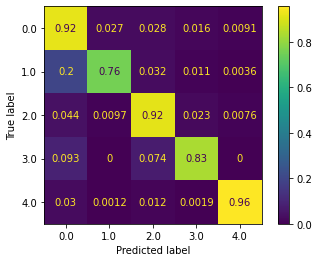

In [ ]:
conf_mat=plot_confusion_matrix(clf,X_test,y_test,normalize='true')

Reduced dataset:

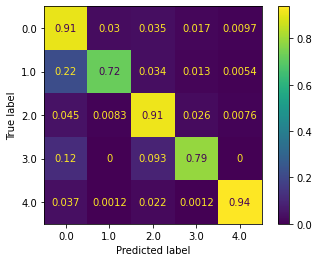

In [ ]:
conf_mat_90=plot_confusion_matrix(clf_90,X_test_90,y_test,normalize='true')

Fitting on the reduced matrix the classifier is worse at many labels (lower accuracies for each square in the diagonal). Nevertheless, values are classified good in both. Improving this will require some cross validation while searching parameters. 

#### Improvements with parameter search

In [ ]:
skf=StratifiedKFold(n_splits=10)

In [ ]:
clf.get_params

<bound method BaseEstimator.get_params of ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)>

The parameter search will converge to three variables: max_depth, max_features and n_estimators. Those have as default values: None, auto and 100. 

The original dataset is obviously slower, since it is bigger dimensionally wise:

In [ ]:
grid_param={'max_depth':np.append(None,np.arange(35,40)),
           'max_features':np.append('auto',np.arange(28,31)),
          'n_estimators':np.arange(95,105)}
GS=GridSearchCV(clf,grid_param,cv=skf,n_jobs=-1,verbose=1)
GS.fit(X_train,y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1894 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 12.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None,
                                            criterion='entropy', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split...
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             

The reduced dataset is faster in terms of computational time:

In [ ]:
GS_param={'max_depth':np.append(None,np.arange(35,40)),
           'max_features':np.append('auto',np.arange(13,16)),
          'n_estimators':np.arange(95,105)}
GS_90=GridSearchCV(clf_90,GS_param,cv=skf,n_jobs=-1,verbose=1)
GS_90.fit(X_train_90,y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 652 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1222 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1906 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 10.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None,
                                            criterion='entropy', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split...
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             

The best configurations for both are of this form:

In [ ]:
print('Original: ',GS.best_params_,'\n With best mean cross-validated score: ',GS.best_score_,
      '\n Reduced: ',GS_90.best_params_,'\n With best mean cross-validated score: ',GS_90.best_score_)

Original:  {'max_depth': 38, 'max_features': 'auto', 'n_estimators': 102} 
 With best mean cross-validated score:  0.95048 
 Reduced:  {'max_depth': 37, 'max_features': 'auto', 'n_estimators': 101} 
 With best mean cross-validated score:  0.9431200000000001


The best classifiers are stored in two variables, and fitted to the train set in order to use them later for comparison.

In [ ]:
clf_gs=GS.best_estimator_
clf_gs_90=GS_90.best_estimator_

Accuracies are saved too:

In [ ]:
acc_gs=accuracy_score(clf_gs.predict(X_test),y_test)
acc_gs_90=accuracy_score(clf_gs_90.predict(X_test_90),y_test)

Doing a random search might (by chance) in this case return a higher performance. Since my first search was not broad and only analyzed 3 parameters, this will be an attempt to find a combination of non-default features, among those which were not taken into account, that might improve accuracy. The explored parameters will be: min_samples_split, min_impurity_decrease and bootstrap. The default values of 2, 0.0 and False are included, as before. In this case, since sampling is random, those are not sure to be explored, but if this happens, the resulting classifier would be random only in less features, which may avoid decreasing too much accuracy. 

In [ ]:
par_rand={'min_samples_split':np.append(2,np.linspace(0.8,1,num=20)),
            'min_impurity_decrease':np.linspace(0,0.2,num=20),
         'bootstrap': np.array([True,False])}

First I randomly search the original matrix:

In [ ]:
RS=RandomizedSearchCV(clf_gs,par_rand,n_iter=250,scoring='accuracy',n_jobs=-1,cv=skf,verbose=1)
RS.fit(X_train,y_train)

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  7.5min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=ExtraTreesClassifier(bootstrap=False,
                                                  ccp_alpha=0.0,
                                                  class_weight=None,
                                                  criterion='entropy',
                                                  max_depth=38,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_s...
       0.15789474, 0.16842105, 0.17894737, 

Then the one that was dimensionally reduced:

In [ ]:
RS_90=RandomizedSearchCV(clf_gs_90,par_rand,n_iter=250,scoring='accuracy',n_jobs=-1,cv=skf,verbose=1)
RS_90.fit(X_train_90,y_train)

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2356 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  7.0min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=ExtraTreesClassifier(bootstrap=False,
                                                  ccp_alpha=0.0,
                                                  class_weight=None,
                                                  criterion='entropy',
                                                  max_depth=37,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_s...
       0.15789474, 0.16842105, 0.17894737, 

Below the best parameters found:

In [ ]:
print('Original: ',RS.best_params_,'\n With best mean cross-validated score: ',RS.best_score_,
      '\n Reduced: ',RS_90.best_params_,'\n With best mean cross-validated score: ',RS_90.best_score_)

Original:  {'min_samples_split': 0.8947368421052632, 'min_impurity_decrease': 0.06315789473684211, 'bootstrap': False} 
 With best mean cross-validated score:  0.48792 
 Reduced:  {'min_samples_split': 0.8736842105263158, 'min_impurity_decrease': 0.0, 'bootstrap': False} 
 With best mean cross-validated score:  0.61616


As for the Mean cross-validated scores, this attempt was not profitable. It seems that using default values leads to a more accurate classifier. There should be no value added in storing their estimators and accuracies. 

#### Understanding performance variability with tuning

As a rule of thumb, spending time to search for an optimal parameter is worthier when performance increases significantly. Obviously, any optimized value is worth when the duration of the assignment is infinite, but since this is not the case I believe this reasoning deserves a sub-chapter. 
The question that I will try to answer is: are two parameters among those included in the grid search worth the exploration? Or is it sufficient to keep the default ones?

In substance, the only step needed is defining a cell which, if given two of those parameters, plots the Mean cross validated score on the z axis against the grid of possible combinations in the xy plane, and another which evaluates its performance when testing. The two parameters chosen are max_depth and n_estimators, and the ranges are equal to the previous grid search. After the plot, the test set accuracy will be stored in a variable. Further analysis will follow. 

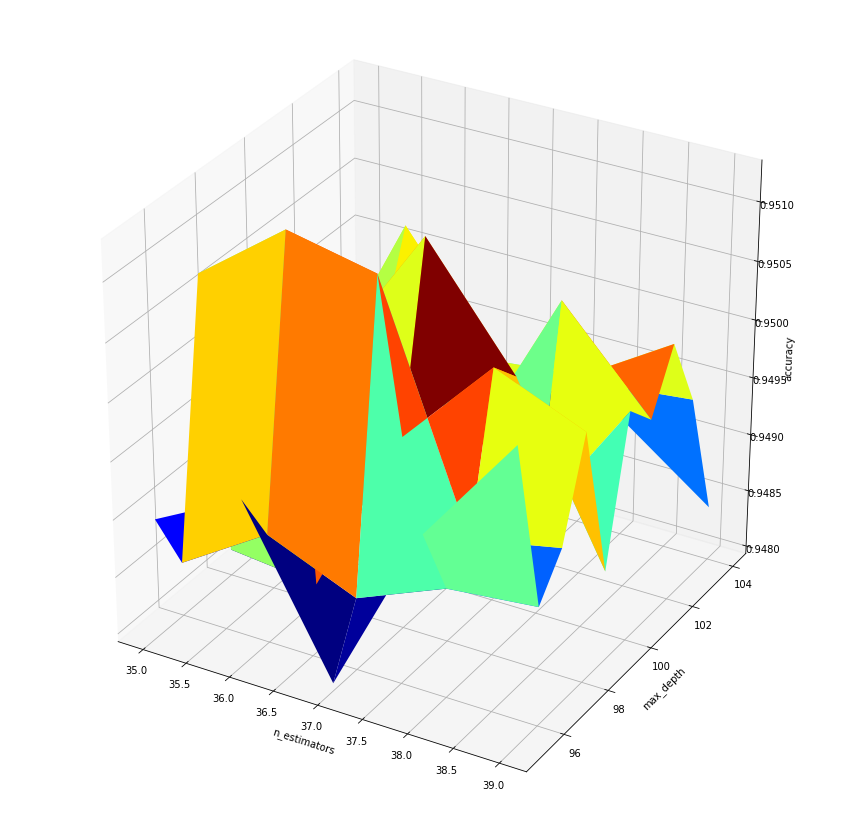

In [ ]:
max_depth=np.arange(35,40) #grid of parameters
n_estimators=np.arange(95,105)
est_scores=np.zeros((5,10))
#best_score=0 old method, found something less expensive computationally
#best_values=[0,0]
for i in range(len(max_depth)):
    for j in range(len(n_estimators)):
        est=ExtraTreesClassifier(max_depth=max_depth[i],n_estimators=n_estimators[j],
                                 max_features='auto') #parameters at each iteration
        scores=cross_val_score(est,X_train,y_train,cv=skf,scoring='accuracy')
        est_scores[i,j]=scores.mean() #mean cv score
       # if scores.mean()>best_score:
        #    best_score=scores.mean()
         #   best_values=[max_depth[i],n_estimators[j]]
best_combination=unravel_index(est_scores.argmax(),est_scores.shape) #faster method
y,x=np.meshgrid(n_estimators,max_depth) 
fig=plt.figure(figsize=(15,15))
ax=fig.gca(projection='3d')
#est_scores.reshape(x.shape)
ax.plot_surface(x,y,est_scores,cmap=cm.jet)
ax.set_ylabel('max_depth')
ax.set_xlabel('n_estimators')
ax.set_zlabel('accuracy')
plt.show()        

After some research & trial and error I noticed that the difference with GridSearchCV is almost inevitable, and due to the implementation of different methods for cross validating as far as I understood (it would be nice to understand this better). Nevertheless, I decided to keep the plot since I spent some time on it, and I will evaluate the performance of this new set of parameters. This reasoning is followed also for the reduced dataset. 

The reduced dataset is almost the same:

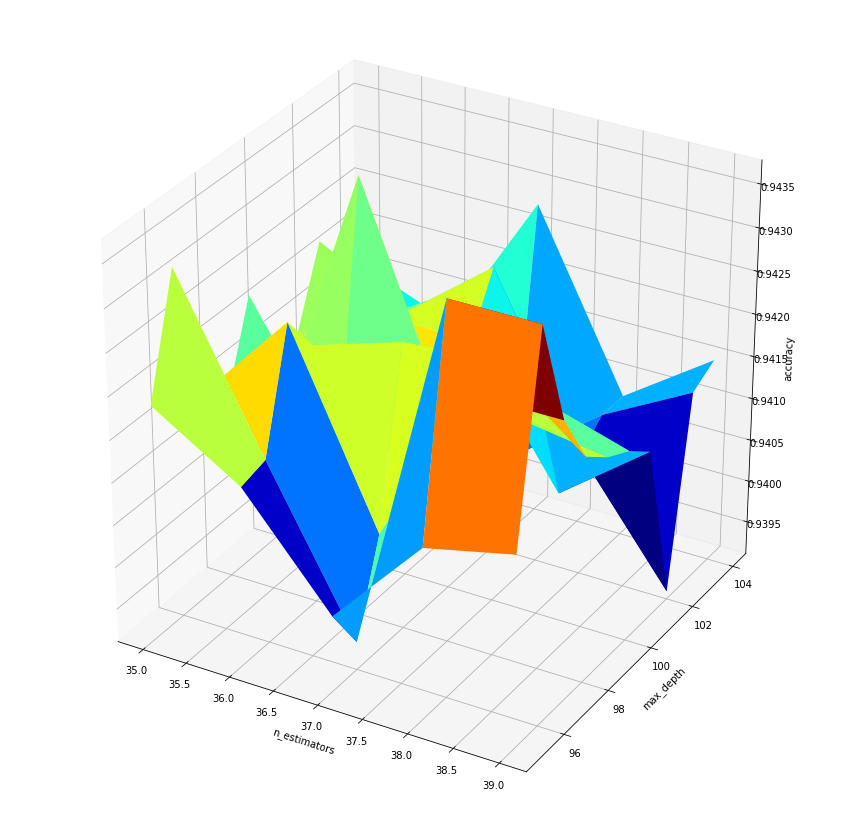

In [ ]:
max_depth=np.arange(35,40) #grid of parameters
n_estimators=np.arange(95,105)
est_scores_90=np.zeros((5,10))
#best_score=0 old method, found something less expensive computationally
#best_values=[0,0]
for i in range(len(max_depth)):
    for j in range(len(n_estimators)):
        est=ExtraTreesClassifier(max_depth=max_depth[i],n_estimators=n_estimators[j],
                                 max_features='auto') #parameters at each iteration
        scores=cross_val_score(est,X_train_90,y_train,cv=skf,scoring='accuracy')
        est_scores_90[i,j]=scores.mean() #mean cv score
       # if scores.mean()>best_score:
        #    best_score=scores.mean()
         #   best_values=[max_depth[i],n_estimators[j]]
best_combination_90=unravel_index(est_scores_90.argmax(),est_scores_90.shape) #faster method
y,x=np.meshgrid(n_estimators,max_depth) 
fig=plt.figure(figsize=(15,15))
ax=fig.gca(projection='3d')
#est_scores.reshape(x.shape)
ax.plot_surface(x,y,est_scores_90,cmap=cm.jet)
ax.set_ylabel('max_depth')
ax.set_xlabel('n_estimators')
ax.set_zlabel('accuracy')
plt.show()        

Below results are printed:

In [ ]:
print('Original best combination: max_depth=',max_depth[best_combination[0]],
      'n_estimators=',n_estimators[best_combination[1]],'CV Score=',
      est_scores[best_combination[0],best_combination[1]],
      '\n Reduced best combination: max_depth=',max_depth[best_combination_90[0]],
      'n_estimators=',n_estimators[best_combination_90[1]],'CV Score=',
      est_scores_90[best_combination_90[0],best_combination_90[1]])

#then we evaluate the performance

Original best combination: max_depth= 36 n_estimators= 97 CV Score= 0.9512799999999999 
 Reduced best combination: max_depth= 36 n_estimators= 100 CV Score= 0.9436800000000002


And estimators & accuracies stored:

In [ ]:
clf_cv=ExtraTreesClassifier(criterion='entropy',
                           max_depth=max_depth[best_combination[0]],
                           n_estimators=n_estimators[best_combination[1]])
clf_cv_90=ExtraTreesClassifier(criterion='entropy',
                           max_depth=max_depth[best_combination_90[0]],
                           n_estimators=n_estimators[best_combination_90[1]])
clf_cv.fit(X_train,y_train)
clf_cv_90.fit(X_train_90,y_train)

acc_cv=accuracy_score(clf_cv.predict(X_test),y_test)
acc_cv_90=accuracy_score(clf_cv_90.predict(X_test_90),y_test)


A visualization of GridSearchCV's variability would require working on its cv_results_ attribute since the previous version of it had a built in function (plot_grid_search), which now does not work since it needs only the cv_results. This would have required some more time. 

#### Comparing performances

Accuracy is a good performance measure. Together with confusion matrices one can easily extract basic information regarding a classifier's behavior. Along with this, I will also evaluate the F1 score, which combines two other measures: precision and recall. 

Test set accuracies point out the best classifiers. However, the relationship between population and sample, which is in this case unknown, might change this statement. A small sample compared to its population points out that a higher accuracy after testing is not necessarily linked with a finer classifier. Nevertheless, if after cross validating the score is higher, this doubt disappears. With python and sklearn this can be easily checked. First, a dictionary with all options is created. 

In [ ]:
d={'basic':clf,'grid':clf_gs,'cv_plot':clf_cv}
d_pca={'basic_90':clf_90,'grid_90':clf_gs_90,'cv_plot_90':clf_cv_90}

Then, after having extracted the most accurate when cross validating, the two methods are compared. A function is built for generalization purposes, so that any two dictionaries of classifiers could be compared. Later on, other measures will be shown.

In [ ]:
clf_found,fr=clash(d,d_pca,X_train,X_test,X_train_90,X_test_90,y_train,y_test,skf=skf)

Original full features estimators: 

Cv score with basic is: 0.9476799999999999
Cv score with grid is: 0.9507199999999999
Cv score with cv_plot is: 0.94888

 Reduced features estimators: 

Cv score with basic_90 is: 0.9406400000000001
Cv score with grid_90 is: 0.9415999999999999
Cv score with cv_plot_90 is: 0.9413600000000001

 The dictionaries of classifiers have been exhaustively searched. 
  
 Test set final analysis
For the first dictionary the best one found is: grid 
 With a cv score of: 0.9507199999999999 
 And a test set accuracy of: 0.9186917595468664
For the second dictionary the best one found is: grid_90 
 With a cv score of: 0.9415999999999999 
 And a test set accuracy of: 0.9032066508313539
Overall, the most reliable one is: grid from the first dictionary


Doubts concerning either reducing or not the dimensionality of the dataset seem cleared as of now. It is clearly evident that a reduction to 95% fo the variance yields worse results when cross validating or testing. Another field of study might have been the choice between standardizing/scaling data or not. Also this should have passed the cross validation test to be accepted in the pipeline. In addition to that, it is quite clear that between searching for parameters and not the improvement is small, and one could argue about its usefulness.

Now that I have in hand the best classifier, here are some scores to better understand its performance.
The choice of the average follows from the unbalancedness of labels and is that of "weighted". As reference I used sklearn's documentation where the authors report under weighted as average:
"Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall."
Since there is no target score for the F-score (f1_score in sklearn), and this dataset is not from a precise industry where this might matter it seemed to me a fair choice if compared to its tradeoff. 

The formulas are here reported, averaging by macro changes them but not significantly: $$Precision=\dfrac{True \; positive}{True \; positive+False \;positive}$$
$$Recall=\dfrac{True \; positive}{True \; positive+False \;negative}$$
$$F-score=\dfrac{Precision * Recall}{Precision+Recall}$$

Accuracy, precision, recall and F-score are saved in order to use them later. 

In [ ]:
clf_found

'grid'

In [ ]:
#since fr='first' we use X_test and y_test
clf_best=d[clf_found]
y_pred=clf_best.predict(X_test)
acc_best=accuracy_score(y_pred,y_test)
prec_best=precision_score(y_pred,y_test,average='weighted')
rec_best=recall_score(y_pred,y_test,average='weighted')
f1_best=f1_score(y_pred,y_test,average='weighted')
print('Precision score is:',prec_best, 
     '\n Recall score is:',rec_best,
     '\n F-score is:',f1_best)

Precision score is: 0.9148745715327965 
 Recall score is: 0.9186917595468664 
 F-score is: 0.9104387201710538


Another useful piece of information is the change in performance with the first classifier built, which used the usual ExtraTreesClassifier, with no transformation and not parameter tuning. First the two will be shown, then a matrix with the percentage of improvement for each cell will be drawn. 

Original, non reduced version:

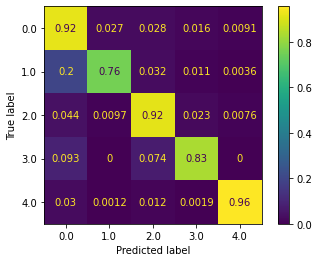

In [ ]:
conf_mat.figure_

Final version:

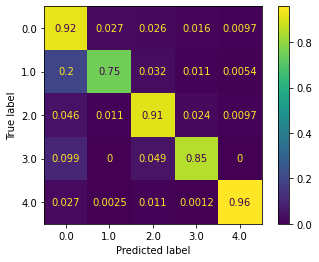

In [ ]:
final_conf_mat=plot_confusion_matrix(clf_best,X_test,y_test,normalize='true')

Improvement: 

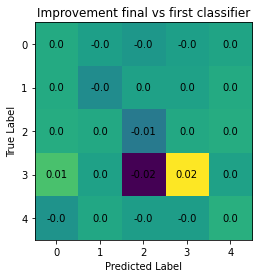

In [ ]:
improvement=final_conf_mat.confusion_matrix-conf_mat.confusion_matrix
fig,ax=plt.subplots()
mat=ax.imshow(improvement)
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
for i in range(5):
    for j in range(5):
        text=ax.text(i,j,round(improvement[j,i],2),ha='center',va='center',color='black')
ax.set_title('Improvement final vs first classifier')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

As the improvement matrix shows, our final classifier behaves more or less in the same way: along the diagonal values are positive or zero, with a slight higher percentage of correctly predicted labels, while out of the diagonal the change is slightly negative. 

### 6 Pipeline and Ensemble

A pipeline is a good way to recap all steps without visualizing. In addition to that, I decided to evaluate the final process chosen taking into account the time spent constructing it. Since it is only an additional step, I also decided to see if accuracy improves by scaling data or using an ensemble of more classifiers through hard voting with VotingClassifier. Then, durations will be compared. The classifier built will be based on the combination of PCA and GridSearchCV, and not on the manual search I did with cross_val_score, hopefully, randomness will not get into the process changing the estimator.
Anyway, this is mainly done to evalute the time performance, and I would also point out that the final accuracy is basically equal to that found before.

In the construction of the Pipeline, in order to use the classifer later I had to do the grid search out of the process. This was done also to obtain the best estimator that will be used later in the ensemble. In addition to that, the dictionary is now adjusted with as keys 'Tree__variable' in order to make the GridSearch understand that it must cycle the parameters of the random forest. In this precise setting, a pipeline may not be used, since we only classify data and do not reduce it, but I decided to save two pipelines. 

As far as the time module is concerned I am aware that it is not that precise.

In [ ]:
t_normal_0=time.time()
GS_param_pipe={'Tree__max_depth':np.append(None,np.arange(35,40)),
           'Tree__max_features':np.append('auto',np.arange(13,16)),
         'Tree__n_estimators':np.arange(95,105)}
pipe_reduced=Pipeline([('PCA',PCA(n_components=0.9)),
            ('Tree',ExtraTreesClassifier(criterion='entropy'))])
pipe=Pipeline([('Tree',ExtraTreesClassifier(criterion='entropy'))])
    
GS_pipe=GridSearchCV(pipe,GS_param_pipe,cv=skf,n_jobs=-1,verbose=1,scoring='accuracy')
GS_pipe.fit(X_train,y_train)
RF_clf=GS_pipe.best_estimator_
t_normal_1=time.time()
delta_t_normal=t_normal_1-t_normal_0

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1892 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 13.2min finished


For the sake of clearness, here below I print the final accuracy, which is slightly different than the one obtained before

In [ ]:
print('Final Cross validation score:',
      np.mean(cross_val_score(RF_clf,X_train,y_train,cv=skf,scoring='accuracy')),
      '\n Final accuracy on the test set:',accuracy_score(RF_clf.predict(X_test),y_test),
     '\n Total time spent:',delta_t_normal)

Final Cross validation score: 0.9490399999999999 
 Final accuracy on the test set: 0.916910286862781 
 Total time spent: 793.7079360485077


It is rather easy to check and plot features' importance in determining the choice, though not much informative since features are "points of sampling".

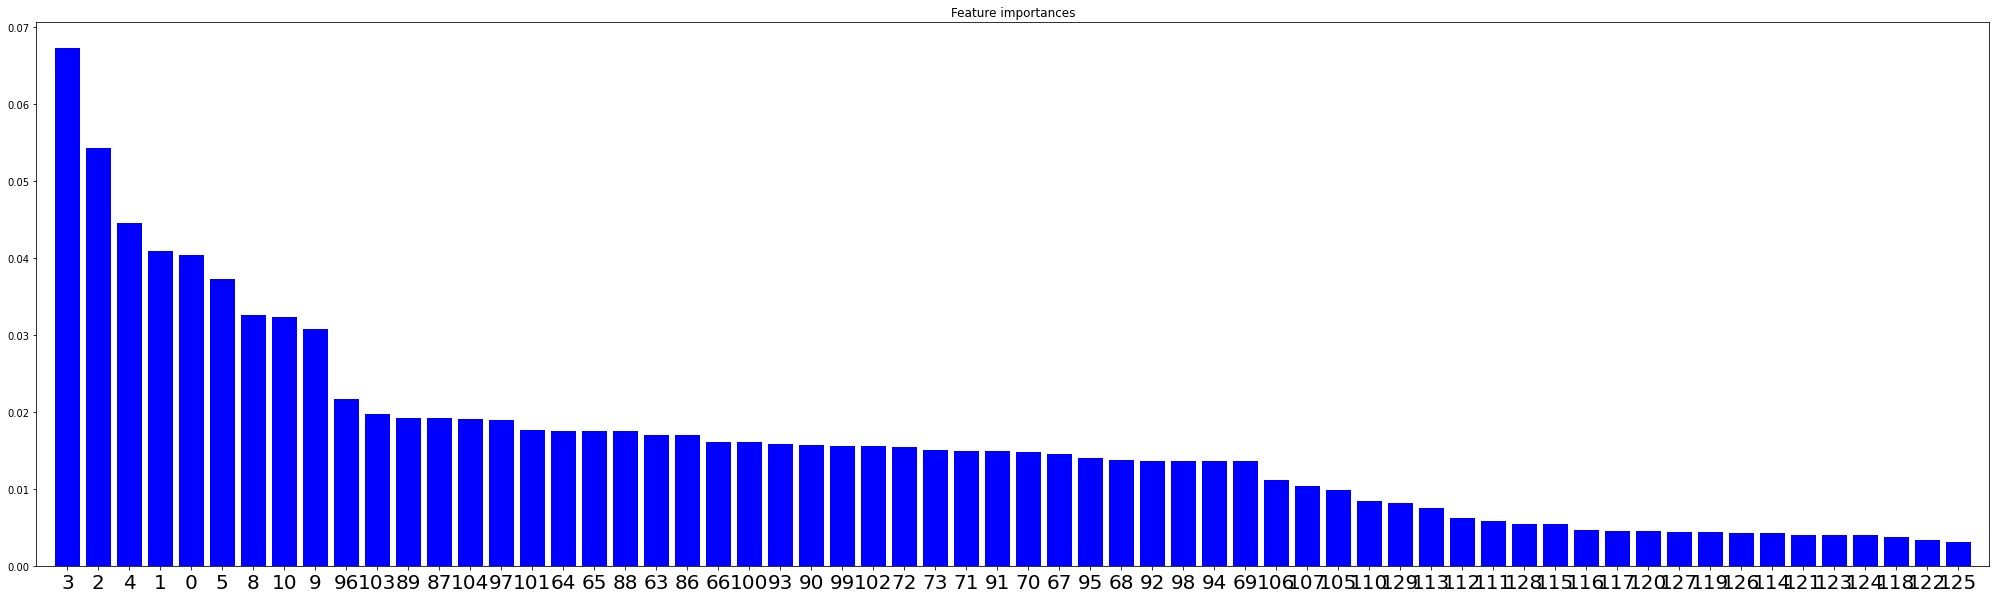

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
def feature_importance_plotter(tree_clf,X_train,figsize=(20,20)):
    importances = tree_clf.feature_importances_
    importances_order = np.argsort(importances)[::-1]
    # Plot the impurity-based feature importances of the forest
    plt.figure(figsize=figsize)
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[importances_order],
            color="b", align="center")
    plt.xticks(range(X_train.shape[1]), df.columns[importances_order],fontsize=20)
    #assumed we are working on a dataset denoted as df
    plt.xlim([-1, X_train.shape[1]])
    plt.show()
    return plt
feature_importance_plotter(RF_clf.steps[0][1],X_train,figsize=(35,10)) #may be a little crowded

The second step is checking if scaled & reduced data performs better. The dictionary used for hyperparameters is the same. I did reduce the dataset's dimensionality but this is something that should be studied more formally, by comparing performances. Both processes are saved in a pipeline for further use. 

In [ ]:
t_std_0=time.time()
pipe_std_reduced=Pipeline([('Scale',StandardScaler()),('PCA',PCA(n_components=0.95)),
        ('Tree',ExtraTreesClassifier(criterion='entropy'))])
pipe_std=Pipeline([('Scale',StandardScaler()),('Tree',ExtraTreesClassifier(criterion='entropy'))])
GS_pipe_std=GridSearchCV(pipe_std_reduced,GS_param_pipe,cv=skf,n_jobs=-1,
                         verbose=1,scoring='accuracy')
GS_pipe_std.fit(X_train,y_train)
RF_std_clf=GS_pipe_std.best_estimator_
t_std_1=time.time()
delta_t_std=t_std_1-t_std_0

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 13.6min finished


In [ ]:
print('Final Cross validation score:',
      np.mean(cross_val_score(RF_std_clf,X_train,y_train,cv=skf,scoring='accuracy')),
      '\n Final accuracy on the test set:',accuracy_score(RF_std_clf.predict(X_test),y_test),
     '\n Total time spent:',delta_t_std)

Final Cross validation score: 0.9359200000000001 
 Final accuracy on the test set: 0.9020190023752969 
 Total time spent: 818.9512875080109


I decided not to propose feature importances when dealing with reduced data since it would have less meaning. A direction of variance's importance is ideal and would not be of tangible utility. Also ROC curve and AUROC score lose their power with multilabel classification. They can be implemented, but given that I did not completely understand how to, I decided to avoid those as well. 

Scaled data is worse in terms of CV score and accuracy. This does not mean that it is a worse choice since other performance measures, depending on the context of the problem, maybe evaluated. In addition to that, since time is around the same of the original, I chose to use it for the ensemble, just to change a little the scheme. In the end, performances do not vary much (around 1%) 

I decided to combine the previous classifer with SVC and MLPClassfier, below I will fit them and then the total final time, accuracy and cross validation accuracy will be evaluated. 

In [ ]:
#take best one already done and gridsearch the voting classsifier
t_svc_0=time.time()
grid_svc={'SVC__C':np.arange(1,10),'SVC__kernel':np.array(['linear','rbf','poly']),
          'SVC__tol':np.array([1e-2,1e-3,1e-4])}
pipe_svc=Pipeline([('Scale',StandardScaler()),('PCA',PCA(n_components=0.9)),
                   ('SVC',SVC())])
GS_pipe_svc=GridSearchCV(pipe_svc,grid_svc,cv=skf,n_jobs=-1,
                         scoring='accuracy',verbose=1)
GS_pipe_svc.fit(X_train,y_train)
svc_clf=GS_pipe_svc.best_estimator_
t_svc_1=time.time()
delta_t_svc=t_svc_1-t_svc_0

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 125.7min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 126.4min finished


In [ ]:
t_mlp_0=time.time()
grid_mlp={'NN__activation':np.array(['logistic','relu']),'NN__solver':np.array(['sgd','adam']),
          'NN__learning_rate_init':np.linspace(0.001,0.01,num=10)}
pipe_NN=Pipeline([('PCA',PCA(n_components=0.9)),
                  ('NN',MLPClassifier())])
GS_pipe_NN=GridSearchCV(pipe_NN,grid_mlp,cv=skf,n_jobs=-1,verbose=1)
GS_pipe_NN.fit(X_train,y_train)
NN_clf=GS_pipe_NN.best_estimator_
t_mlp_1=time.time()
delta_t_mlp=t_mlp_1-t_mlp_0

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 54.9min finished


I chose not to search for this classifer's parameters but this could have been done, especially for what concerns the weights, which will be uniform. An interesting point of research would have been checking if it is actually useful to consider them, or if their optimal weight is zero. 

In [ ]:
t_voting_0=time.time()
v_clf=VotingClassifier([('Random Standardized Forest',RF_std_clf),('SVC',svc_clf),('Neural Network',NN_clf)])
v_clf.fit(X_train,y_train)
t_voting_1=time.time()
delta_t_voting=t_voting_1-t_voting_0

In [ ]:
y_pred_v=v_clf.predict(X_test)
acc_v=accuracy_score(v_clf.predict(X_test),y_test)
prec_v=precision_score(y_pred_v,y_test,average='weighted')
rec_v=recall_score(y_pred_v,y_test,average='weighted')
f1_v=f1_score(y_pred_v,y_test,average='weighted')
delta_t_v=delta_t_voting+delta_t_mlp+delta_t_svc+delta_t_std
print('Final Cross validation score:',
      np.mean(cross_val_score(v_clf,X_train,y_train,cv=skf,scoring='accuracy')),
      '\n Final accuracy on the test set:',acc_v,
      '(+',np.round((acc_v-acc_best)/acc_best,2)*100,'%)',
      '\n Final Precision:',prec_v,
      '(+',np.round((prec_v-prec_best)/prec_best,2)*100,'%)',
      '\n Final Recall:',rec_v,
      '(+',np.round((rec_v-rec_best)/rec_best,2)*100,'%)',
      '\n Final F-score:',f1_v,
      '(+',np.round((f1_v-f1_best)/f1_best,2)*100,'%)',
     '\n Total time spent:',delta_t_v,
     '(+',np.round((delta_t_v-delta_t_normal)/delta_t_normal,2)*100,'%)')

Final Cross validation score: 0.9117599999999999 
 Final accuracy on the test set: 0.8679883062305865 (+ -6.0 %) 
 Final Precision: 0.8626097081176176 (+ -6.0 %) 
 Final Recall: 0.8679883062305865 (+ -6.0 %) 
 Final F-score: 0.842239398437267 (+ -7.000000000000001 %) 
 Total time spent: 11727.518877029419 (+ 1378.0 %)


An ensemble of classifiers, without much effort, has lower CV score and lower accuracy. This is probably due to the fact that classifiers were not tuned well and that weights should not be uniform across them. Below the final confusion matrices of the VotingClassifer and the difference with the first one:

The basic ExtraTreesClassifier

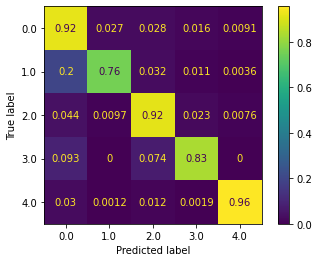

In [ ]:
conf_mat.figure_

VotingClassifier with (Scaled,PCA,ExtraTreesClassifer ; Support Vector Machine ; Neural Network MLP CLassifier) version:

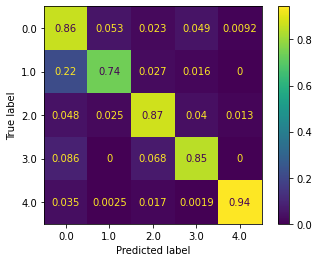

In [ ]:
voting_conf_mat=plot_confusion_matrix(v_clf,X_test,y_test,normalize='true')

Improvement: 

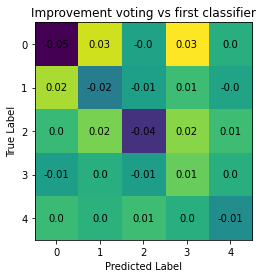

In [ ]:
improvement_voting=voting_conf_mat.confusion_matrix-conf_mat.confusion_matrix
fig,ax=plt.subplots()
mat=ax.imshow(improvement_voting)
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
for i in range(5):
    for j in range(5):
        text=ax.text(i,j,round(improvement_voting[j,i],2),ha='center',va='center',color='black')
ax.set_title('Improvement voting vs first classifier')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

Reasoning on the final chapter, we could argue that the voting classifier, without allowing for a finer tuning, should not be chosen. 

This process has returned two classifiers with the following features (after GridSearching them):

In [ ]:
RF_std_clf

Pipeline(memory=None,
         steps=[('Scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('Tree',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='entropy',
                                      max_depth=36, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=102, n_jobs=None,
      

In [ ]:
v_clf.estimators #with uniformly weighed vote

[('Random Standardized Forest', Pipeline(memory=None,
           steps=[('Scale',
                   StandardScaler(copy=True, with_mean=True, with_std=True)),
                  ('PCA',
                   PCA(copy=True, iterated_power='auto', n_components=0.95,
                       random_state=None, svd_solver='auto', tol=0.0,
                       whiten=False)),
                  ('Tree',
                   ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=36, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
             

Allowing for some more computations, the attempt to create a more complex ensemble of classifiers was successful. However, in my not expert opinion, I would not choose it without studying more its parameters. Finer and thoughtful tuning would be needed to give a reasonable answer. 